# Introducing User Defined Function Reranking

Vectara has several out of the box rerankers, including [Maximal Marginal Revelance (MMR)](https://docs.vectara.com/docs/learn/vectara-multi-lingual-reranker) and a [Multilingual Reranker](https://docs.vectara.com/docs/learn/mmr-reranker).

If you would like more control over how the search results are reranked, the [User Defined Function (UDF)](https://docs.vectara.com/docs/learn/user-defined-function-reranker) reranker is just for you! This reranker gives you the ability to use different operators and expressions to define how your retrieved search results are reranked based on document or part [metadata](https://docs.vectara.com/docs/learn/document-data-structuring#metadata).

It is common to combine multiple rerankers with our [chain reranker](https://docs.vectara.com/docs/learn/chain-reranker), allowing you to finely tune how retrieved results are ordered. If you are using multiple reranker, we recommend the reranking in this sequence: 

1. Multilingual
2. MMR
3. UDF

The MMR and UDF rerankers both take as input the score from the previous stage in the chain reranking setting. However, the multilingual reranker is context-free and thus always reranks results independent of what reranker appears before it in the chain, thus if you use the multilingual reranker, it must be used as the first step in the chain. 

In this notebook, we will demonstrate many of the capabilities of the UDF reranker using a corpus that contains reviews for Airbnb listings in Barcelona. We will compare the results of using the UDF reranker in the above reranking chain against the same query that uses the multilingual and MMR rerankers.

In [1]:
import os

corpus_key = os.getenv("VECTARA_CORPUS_KEY")
api_key = os.getenv("VECTARA_API_KEY")

## Basic Sorting

Let's start off with a simple use case with UDF reranking. When looking for an Airbnb, you will probably be most interested in the highest rated Airbnb listings. To do this, we will add a function to our rerank chain that favors reviews on listings with higher ratings. This function will be:

`5 * get('$.score') + get('$.part_metadata.overall_rating')`

In almost every UDF function, you will see `get('$.score')`. This function retrieves the current reranking score for each of the documents based on the previous retrieval and reranking step. At the the first step of reranking, this value depends on the embedding model, and will range between 0 to 1. After this, the range of the score will depend on the specific reranker in each step. One important thing to keep in mind when defining your user defined functions is that this score should always be non-negative, so make sure that any function you define always outputs non-negative values.

The number 5 in the above expression is somewhat arbitrary. This coefficient is simply scaling the weight between the importance of the previous reranking score and the overall rating of the Airbnb listing. You may have to play with these sorts of coefficients until you get the desired scaling for your application. When testing with different values, consider the possible range of values for each of the variables in your expression. In our expression, the `$.score` will range from 0 to 1 and the `$.part_metadata.overall_rating` (which is a metadata field) will range from 1 to 5 (because the star rating system on Airbnb ranges from 1 to 5).

Let's now see how to include this function in an API request and compare the results against an example that does not use this expression:

In [36]:
# Without UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "There were ants everywhere.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.1,
          "limit": 10
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [37]:
for result in res['search_results']:
    print(f"Text: {result['text']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\n")

Text: Our only problem was that there were a lot of little ants everywhere, which we have let the host know about.
Score: 0.9991990923881531
Overall Rating: 4.55

Text: There were ants everywhere, sofa bed was broken, had someone from court show up at the door asking for someone that maybe owned the property?
Score: 0.8103337287902832
Overall Rating: 4.32

Text: Disappointing stay. There were ants crawling all over the kitchen area and parts of the hallway.
Score: 0.8084042072296143
Overall Rating: 4.52

Text: Ants are everywhere.
Score: 0.8077003359794617
Overall Rating: 3.0

Text: There were ants everywhere I was afraid to leave my suitcase on the floor.
Score: 0.8065652251243591
Overall Rating: 4.33

Text: The presence of ants crawling everywhere on the ground was a major hygiene concern.
Score: 0.8059450387954712
Overall Rating: 4.48

Text: The AC didnt work and there were ants everywhere.
Score: 0.805853009223938
Overall Rating: 4.45

Text: There were ants around the house, not ma

In [38]:
# With UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "There were ants everywhere.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "5 * get('$.score') + get('$.document_metadata.overall_rating')",
          "limit": 10
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [39]:
for result in res['search_results']:
    print(f"Text: {result['text']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\n")

Text: Our only problem was that there were a lot of little ants everywhere, which we have let the host know about.
Score: 9.545995712280273
Overall Rating: 4.55

Text: There were ants in several areas of the apartment.
Score: 7.989143371582031
Overall Rating: 4.92

Text: There were ants in the kitchen and in the bathrooms.
Score: 7.865470886230469
Overall Rating: 4.83

Text: Lots of Ants everywhere, even without the food.
Score: 7.847082138061523
Overall Rating: 4.8

Text: There were many ants throughout the condo and worse bugs in the bedrooms.
Score: 7.833558559417725
Overall Rating: 4.79

Text: It was very bad especially the first two days -Ants everywhere.
Score: 7.784627437591553
Overall Rating: 4.73

Text: And there are ants throughout the apartment.
Score: 7.755528926849365
Overall Rating: 4.83

Text: There were a little ants, however it was not problem for us.
Score: 7.6856489181518555
Overall Rating: 4.77

Text: (We are not big people) There were tiny ants in the kitchen when 

Notice how both result sets contain reviews that complained about finding lots of ants (a drawback of the Airbnb), but the second set of results that includes the UDF reranker have higher overall ratings.

Another important thing to notice is the number of results returned by our queries. We set the `limit` parameter as 50 in the search configuration. This means that the top 50 results will be intially retrieved. These results are then passed to our reranker. Ultimately, the number of results returned is only 10 because we specified the parameter `limit` as 10 within the udf reranker. 

Within the chain reranker, you can specify the `limit` parameter on any reranker in the chain. This will limit the number of total results that are passed on to the next reranker in the chain. In general, it is a good idea to start with a fairly large number of search results (at least 50) and then funnel the results as you get further into your rerank chain.

## Math Operations

Another important consideration when choosing the right Airbnb is the location. Suppose that you want to find an Airbnb that is close to many of the top attractions in Barcelona so that your travel time is minimized on your trip. We can add a user defined function that calculates the distance between the Airbnb and another location, such as Casa Batlló, a historic landmark in Barcelona that is close to other popular attractions like Basílica de la Sagrada Família and Plaça de Catalunya. 

To calculate the distance between each Airbnb and this attraction, we will use the latitude and longitude coordinates of the Airbnb and calculate the distance to Casa Batlló (latitude: 41.39283635783124, longitude: 2.164614185406772) using the [equirectangular approximation](http://www.weatherclasses.com/uploads/1/3/1/3/131359169/distance_calculations_revised.pdf), defined as $$R* \sqrt{\Delta\phi^2 + (cos(\frac{\phi_1 + \phi_2}{2}) * \Delta\lambda)^2},$$

where $R$ is the radius of Earth (about 6371 km) $\phi_1$ and $\phi_2$ are the latitudes of the two points in radians and $\lambda_1$ and $\lambda_2$ are the longitudes of the two points in radians.

For example, if we want to calculate the distance between Basílica de la Sagrada Família (latitude: 41.4037272046833, longitude: 2.174643481526023) and Spotify Camp Nou (latitude: 41.380900633873445, longitude: 2.123142814772147), the stadium where Barcelona plays, we will use the latitude and longitude of these locations and plug them into the above equation (Remember that these coordinate values are in degrees, so we must convert them to radians first):

$$\phi_1 = 41.4037272046833 (\frac{\pi}{180}) = 0.722711$$
$$\phi_2 = 41.380900633873445 (\frac{\pi}{180}) = 0.722312$$
$$\lambda_1 = 2.174643481526023 (\frac{\pi}{180}) = 0.037954$$
$$\lambda_2 = 2.123142814772147 (\frac{\pi}{180}) = 0.037055$$

$$Distance \approx 6371 * \sqrt{(0.722312 - 0.722711)^2 + (cos(\frac{0.722711 + 0.7223125}{2}) * (0.037055 - 0.037954))^2} = 4.99 km$$

Since the radius of Earth is just a constant and we don't care about the actual value outputted by this function, we will remove this constant from our distance calculation in the `user_function`. Using the available functions in the UDF reranker, we get:

`get('$.score') -  400 * sqrt(power(radians(get('$.document_metadata.latitude')) - radians(41.39283635783124)), 2) + power(cos((radians(get('$.document_metadata.latitude')) + radians(41.39283635783124)) / 2) * (radians(get('$.document_metadata.longitude')) - radians(2.164614185406772)), 2))`

Once again, the coefficient of 400 is sort of arbitrary, but we select this value based on how much we want to weigh the importance of the previous reranking score with the distance from the Airbnb to Casa Batlló.

Let's see how the results differ when we add in this UDF reranker.

In [2]:
# Without UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2,
          "limit": 20
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [3]:
for result in res['search_results']:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nLatitude: {result['document_metadata']['latitude']}\nLongitude: {result['document_metadata']['longitude']}\n")

Review: Great Airbnb with everything you could think of, very close to good food and a short walk to the beach. Hugo was lovely on arrival and even gave us a bottle of champagne for our honeymoon. The Airbnb has a good kitchen and living area. Hugo and Loannis have a very unique style which we enjoyed. My one gripe is Hugo made us feel very uncomfortable when he accused us of leaving the kitchen messy. The kitchen is shared and there were no bins to put bottles in which means bottles were left next to the bin. Another guest had used the kitchen and left it quite messy. Either way it was very unprofessional and made our stay awkward from that point on. If it werent for this, this would be the perfect Airbnb.
Score: 0.949669361114502
Latitude: 41.38408
Longitude: 2.18334

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great l

In [4]:
# With UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "get('$.score') -  400 * sqrt(power(radians(get('$.document_metadata.latitude')) - radians(41.39283635783124), 2) + power(cos((radians(get('$.document_metadata.latitude')) + radians(41.39283635783124)) / 2) * (radians(get('$.document_metadata.longitude')) - radians(2.164614185406772)), 2))",
          "limit": 20
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

udf_response = requests.request("POST", url, headers=headers, data=payload)
udf_res = udf_response.json()

In [5]:
for result in udf_res['search_results']:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nLatitude: {result['document_metadata']['latitude']}\nLongitude: {result['document_metadata']['longitude']}\n")

Review: Great Airbnb with everything you could think of, very close to good food and a short walk to the beach. Hugo was lovely on arrival and even gave us a bottle of champagne for our honeymoon. The Airbnb has a good kitchen and living area. Hugo and Loannis have a very unique style which we enjoyed. My one gripe is Hugo made us feel very uncomfortable when he accused us of leaving the kitchen messy. The kitchen is shared and there were no bins to put bottles in which means bottles were left next to the bin. Another guest had used the kitchen and left it quite messy. Either way it was very unprofessional and made our stay awkward from that point on. If it werent for this, this would be the perfect Airbnb.
Score: 0.834098219871521
Latitude: 41.38408
Longitude: 2.18334

Review: Best Airbnb weve stayed in. The location is PERFECT to see everything in the city. I would recommend this airbnb to everyone traveling to Barcelona - two bedrooms, two full bathrooms, full sized kitchen, dining,

### Geo-location UDF in action

Let's see how the UDF works visually.

We can plot the top results returned by the query on a map of Barcellona, and see if indeed the results returned by the query with the UDF reranker are closer to the main attractions in Barcelona compared to the query that does not use the UDF reranker.

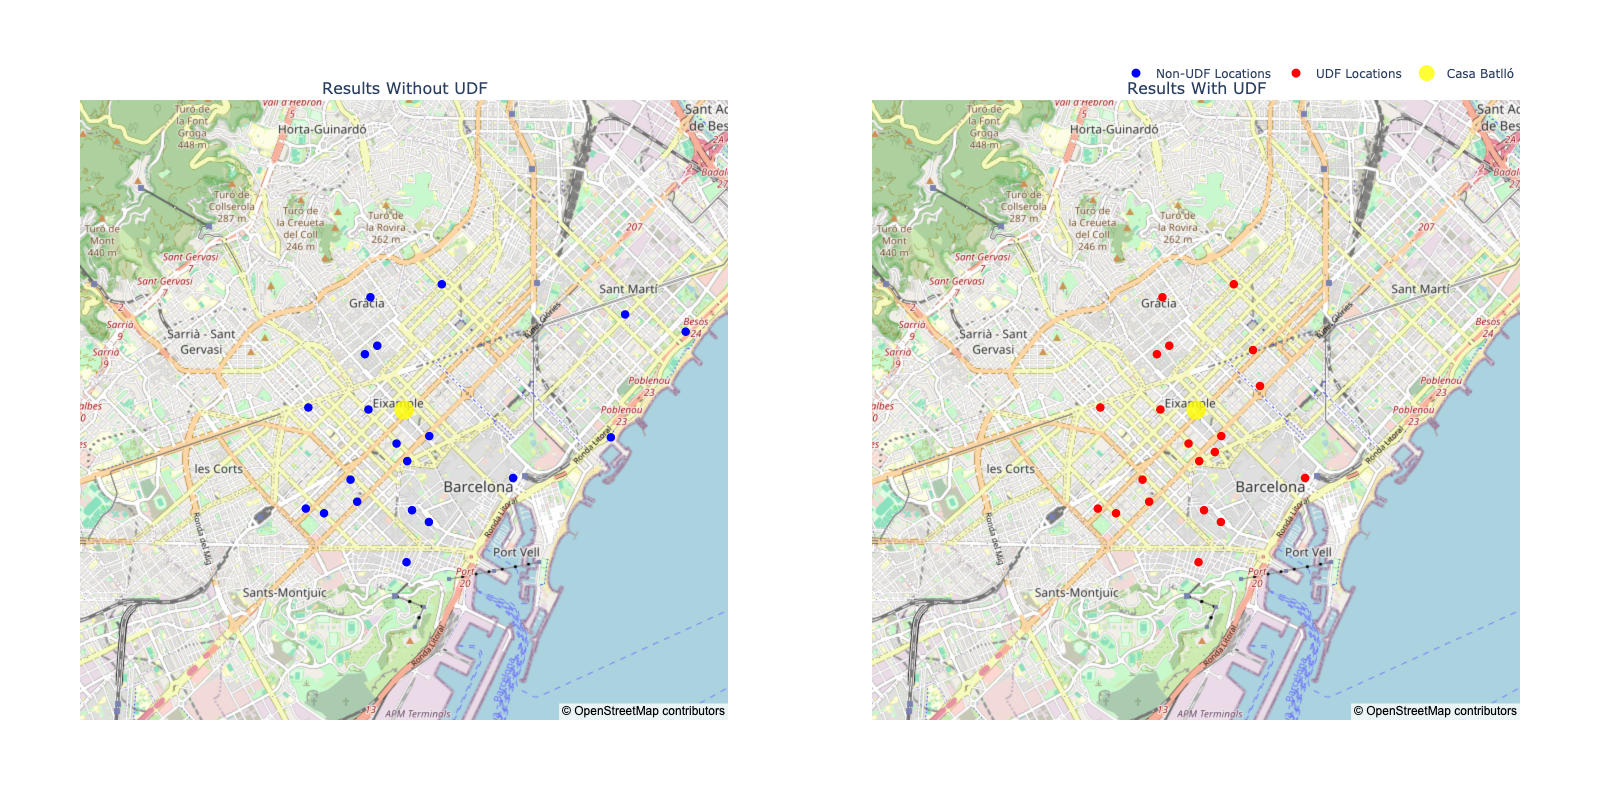

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

fig = make_subplots(rows=1, cols=2, subplot_titles=("Results Without UDF", "Results With UDF"), 
                    specs=[[{'type': 'scattermapbox'}, {'type': 'scattermapbox'}]])

# First plot
latitudes = []
longitudes = []
labels = []
for result in res['search_results']:
    latitudes.append(float(result['part_metadata']['latitude']))
    longitudes.append(float(result['part_metadata']['longitude']))
    labels.append(result['part_metadata']['title'])

fig.add_trace(go.Scattermapbox(
    lat=latitudes,
    lon=longitudes,
    mode='markers',
    marker=dict(size=9, color='blue'),
    text=labels,
    hoverinfo='text',
    name='Non-UDF Locations'
), row=1, col=1)

# Special point for first graph
fig.add_trace(go.Scattermapbox(
    lat=[41.39283635783124],
    lon=[2.164614185406772],
    mode='markers',
    marker=dict(size=20, color='yellow', opacity=0.8),
    text=['Casa Batlló'],
    hoverinfo='text',
    showlegend=False
), row=1, col=1)

# Second plot (UDF Points)
latitudes = []
longitudes = []
labels = []
for result in udf_res['search_results']:
    latitudes.append(float(result['part_metadata']['latitude']))
    longitudes.append(float(result['part_metadata']['longitude']))
    labels.append(result['part_metadata']['title'])

fig.add_trace(go.Scattermapbox(
    lat=latitudes,
    lon=longitudes,
    mode='markers',
    marker=dict(size=9, color='red'),
    text=labels,
    hoverinfo='text',
    name='UDF Locations'
), row=1, col=2)

# Special point for second graph
fig.add_trace(go.Scattermapbox(
    lat=[41.39283635783124],
    lon=[2.164614185406772],
    mode='markers',
    marker=dict(size=20, color='yellow', opacity=0.8),
    text=['Casa Batlló'],
    hoverinfo='text',
    name='Casa Batlló'
), row=1, col=2)

# Update layout
fig.update_layout(
    autosize=True,
    hovermode='closest',
    width=1600,
    height=800,
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=41.39283635783124, lon=2.164614185406772),
        zoom=12
    ),
    mapbox2=dict(
        style="open-street-map",
        center=dict(lat=41.39283635783124, lon=2.164614185406772),
        zoom=12
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# fig.show()

fig.write_image("plot.png")
Image("plot.png")

Both of these maps contain many of the same Airbnb locations, but notice how more of the locations in the right graph are concentrated around the yellow dot while some of the points in the left graph are further away (e.g., the two blue dots that are near Sant Martí in the left graph).

## Temporal Ordering

In many applications, it may be important to sort the results based on temporal variables such as date or time. For our example, we would likely want to see the most recent reviews because those most accurately reflect the current state of the Airbnb. However, we do not want to completely ignore the relevancy of the review's content to our query. Thus, we will use the amount of time since the review was posted as a penalty to the original document score.

Since dates can go back a long time, we will ensure that the final document score is non-negative by taking the maximum of the udf calculation and 0. Our user defined function for this example is

`max(10 * get('$.score') - hours(seconds(to_unix_timestamp(now()) - to_unix_timestamp(datetime_parse(get('$.part_metadata.review_date'), 'yyyy-MM-dd')))) / 24 / 365, 0)`

Let's break down the steps:

1. First, we converted all of our date strings to `datetime` objects (specifically, the `review_date`), specifying the format of the date strings.
2. Next, we converted these dates to the number of seconds from the epoch using `to_unix_timestamp()`.
3. We then used the `seconds()` function to indicate that the number we got from our previous operation is a duration in seconds.
4. After this, we used the `hours()` function to convert the seconds duration object to the number of hours between these two dates.
5. Then we calculated the number of years between these two dates by dividing by the number of hours in a day (24) and number of days in a year (365).
6. Finally we specify the output of the UDF to be 10 times the previous score, minus the number of years. This means the penalty is proportional to the number of years since the review was submitted, with 10 years being the maximum (since we make sure it's not negative). 

In [43]:
# Without UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2,
          "limit": 10
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [10]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nDate: {result['part_metadata']['review_date']}\n")

Review: Great Airbnb with everything you could think of, very close to good food and a short walk to the beach. Hugo was lovely on arrival and even gave us a bottle of champagne for our honeymoon. The Airbnb has a good kitchen and living area. Hugo and Loannis have a very unique style which we enjoyed. My one gripe is Hugo made us feel very uncomfortable when he accused us of leaving the kitchen messy. The kitchen is shared and there were no bins to put bottles in which means bottles were left next to the bin. Another guest had used the kitchen and left it quite messy. Either way it was very unprofessional and made our stay awkward from that point on. If it werent for this, this would be the perfect Airbnb.
Score: 0.949669361114502
Date: 2018-04-11

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great location for seeing ev

In [40]:
# With UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "max(10 * get('$.score') - hours(seconds(to_unix_timestamp(now()) - to_unix_timestamp(datetime_parse(get('$.part_metadata.review_date'), 'yyyy-MM-dd')))) / 24 / 365, 0)",
          "limit": 10
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [12]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nDate: {result['part_metadata']['review_date']}\n")

Review: Best Airbnb weve stayed in. The location is PERFECT to see everything in the city. I would recommend this airbnb to everyone traveling to Barcelona - two bedrooms, two full bathrooms, full sized kitchen, dining, living room, and incredible views.
Score: 5.443197250366211
Date: 2024-06-21

Review: The apartment is really spacious and well appointed, in a really great location to explore Barcelona on foot. Its a shot walk to La Rambla and all it has to offer, as well as the gothic quarter, the high end shopping areas, and Modernisme buildings like Casa Batll. Matteo was wonderful - constant attention via messaging, immediately answering any and all questions. He met us on arrival, showed us everything in the apartment, and gave us local recommendations on a map. We could not have had a better introduction. Amenities are perfect - a full kitchen (curiously no microwave but has an oven), roomy dining and living rooms, 3 bathrooms and good sized bedrooms. You will really be able to 

Notice how all but one of the reviews returned by the query with the UDF date penalty are dated 2022 or later. The only result that is older than that is one review from 2018 which had the best semantic score when no udf was used. This demonstrates the great balance that can be achieved by using user defined functions in a rerank chain.

## Conditional Expressions

The last aspect that we will cover in this notebook is conditional expressions. These allow you to condition the function used to calculate the reranking score. For example, suppose that you would like to give preference to Airbnbs with high overall ratings, but you will likely be more trusting of the rating if there are a large number of total reviews. We can use conditional expressions to complete this task.

Note the difference here between using conditional expressions in your `user_function` and using a `metadata_filter`. If you want to only include Airbnb results that satisfy a particular requirement, add this to the [metadata_filter](https://docs.vectara.com/docs/learn/metadata-search-filtering/filter-overview). 

For example, if you need at least 4 beds in the Airbnb to fit everyone in your family, you should include this as a metadata filter: `"metadata_filter": "doc.number_of_beds >= 4"`. 

On the other hand, if you want to change your calculation based on some metadata, you can add this as a condition to your `user_function`. In this example, we will favor Airbnbs that have at least 300 reviews by giving a multiplier to the scores of those Airbnbs. Here is the `user_function` that we will use for this:

`if (get('$.document_metadata.number_of_reviews') >= 300) 5 * get('$.score') + 1.25 * get('$.document_metadata.overall_rating') else 5 * get('$.score') + get('$.document_metadata.overall_rating')`

Let's compare the results when using a UDF function without conditional expression vs. with a conditional expression:

In [13]:
# Without Conditional Expression

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    # "metadata_filter": "doc.number_of_beds >= 4",
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "5 * get('$.score') + get('$.document_metadata.overall_rating')",
          "limit": 10
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [14]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\nNumber of Reviews: {result['part_metadata']['number_of_reviews']}\nNumber of Beds: {result['document_metadata']['number_of_beds']}\n")

Review: Great Airbnb with everything you could think of, very close to good food and a short walk to the beach. Hugo was lovely on arrival and even gave us a bottle of champagne for our honeymoon. The Airbnb has a good kitchen and living area. Hugo and Loannis have a very unique style which we enjoyed. My one gripe is Hugo made us feel very uncomfortable when he accused us of leaving the kitchen messy. The kitchen is shared and there were no bins to put bottles in which means bottles were left next to the bin. Another guest had used the kitchen and left it quite messy. Either way it was very unprofessional and made our stay awkward from that point on. If it werent for this, this would be the perfect Airbnb.
Score: 9.498346328735352
Overall Rating: 4.75
Number of Reviews: 273
Number of Beds: 1

Review: She is so cheerful, and fun, she was kind enough to show me around when she had time :), two awesome doggos!! Flexible, easy-going, and stress-free. that's what you want in an airbnb!
Sco

In [15]:
# With Conditional Expression

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "metadata_filter": "doc.number_of_beds >= 4",
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 50,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "if (get('$.document_metadata.number_of_reviews') >= 300) 5 * get('$.score') + 1.25 * get('$.document_metadata.overall_rating') else 5 * get('$.score') + get('$.document_metadata.overall_rating')",
          "limit": 10
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [16]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\nNumber of Reviews: {result['part_metadata']['number_of_reviews']}\nNumber of Beds: {result['document_metadata']['number_of_beds']}\n")

Review: location wise was perfect,  amenities and general shape of the  apartment was good too, the place was bigger than I was expecting (which is a good thing, specially for more than 1 couple, you are going to have privacy ). A full equipped kitchen, washing machine and a nice dinning room. Omar was very helpful, aside of receiving us at the defined time, he was friendly and gave us a few recommendations on what to eat and general tips
Score: 9.333236694335938
Overall Rating: 4.56
Number of Reviews: 216
Number of Beds: 5

Review: the appartment is nice, big enough for small group. beds are fit for singles. kitchen, dining room- very well. bathroom is also good. everything is working well. Isidre is ready to help in everything. that was a pleasure and i do recommend this appartment.
Score: 8.690791130065918
Overall Rating: 4.86
Number of Reviews: 406
Number of Beds: 4

Review: Affordable flat in a great location, 5 mins from Parallel metro station and lots of nice little cafes and sh

Notice how the results with more reviews tend to be higher up on the list of retrieved documents, even if their overall rating scores are slightly lower than some of the other Airbnbs below them in the search results. 

We also applied a metadata filter in the second query so that the number of beds in the Airbnb is at least 4.

## Summary

In this notebook, we introducted the user defined function reranker that allows you as a user to choose how your retrieved documents are reranked based on document and part metadata. We have seen a variety of examples and function groups that can be used with our user defined reranker, including mathematic expressions, datetime functions, and conditional expressions. These are the general function groups that you can use with our UDF reranker, but the actual number of functions that you can write are infinite. We also showed that using the UDF reranker works best as part of a chain of rerankers, with the UDF reranker being the last reranker in the chain.

If you have any questions about the examples or explanations in this notebook, please ask on our [forums](https://discuss.vectara.com/), [user community](https://vectara.com/developers/community/), or [Discord](https://discord.com/invite/GFb8gMz6UH).